In [3]:
import numpy as np
import pandas as pd

In [4]:
cd script/


/Users/tarindujayatilaka/Documents/CSE/Machine Learning /Fare Classification/script


In [5]:
train_df = pd.read_csv('../train.csv',index_col="tripid")

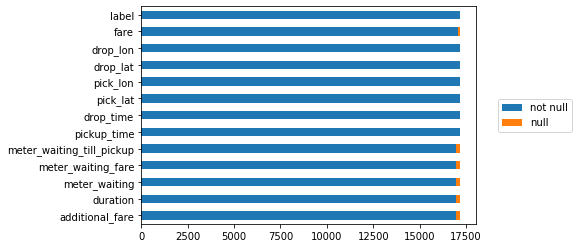

In [6]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

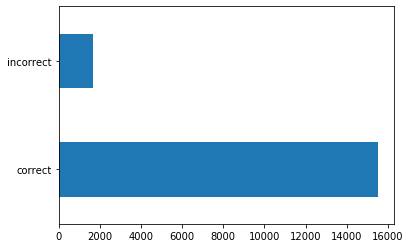

In [7]:
train_df['label'].value_counts().plot.barh()

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler

RANDOM_SEED = 42  

In [9]:
labels_raw_df = train_df.loc[:, train_df.columns == 'label']
features_raw_df = train_df.drop(columns=['label'])

In [10]:
def preprocess_labels(input_labels_df):
  labels_df = input_labels_df
  labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
  
  labels_df.columns = labels_df.columns
  labels_df.index = labels_df.index

  return labels_df  

In [11]:
labels_df = preprocess_labels(labels_raw_df)

In [12]:
def preprocess_features(input_features_df):
    features_df = input_features_df.copy()

    numeric_cols = features_df.columns[features_df.dtypes != "object"].values
    imputer = SimpleImputer(strategy='mean')
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

    #date time
    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])

    #duration
    features_df['duration_fill'] = (features_df['drop_time'] - features_df['pickup_time']).dt.total_seconds()
    features_df['duration'] = features_df['duration'].fillna(features_df['duration_fill'])

    features_df = features_df.drop(columns=['duration_fill'])

    #travel time
    features_df['travel_time'] = features_df['duration'] - features_df['meter_waiting']

    #waiting time
    features_df['waiting_time'] = features_df['meter_waiting'] + features_df['meter_waiting_till_pickup']

    #distance fare
    features_df['distance_fare'] = features_df['fare'] - features_df['meter_waiting_fare'] - features_df['additional_fare']

    #distance
    features_df['manhattan_distance'] = abs(features_df['drop_lat'] - features_df['pick_lat']) + abs(features_df['drop_lon'] - features_df['pick_lon'])

    #fare per distance unit
    #features_df['fare_per_distance_unit'] = features_df['distance_fare']/features_df['manhattan_distance']

    #fare per time unit
    #features_df['fare_per_time_unit'] = features_df['distance_fare']/features_df['manhattan_distance']

    #travel speed
    #features_df['speed'] = features_df['manhattan_distance']/features_df['travel_time']

    #get day of the week
    #features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
    #features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()

    features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
    features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60


    #encode cyclic 24 hours with sin and cos
    features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
    features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

    features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
    features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)

    #features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])

    features_df = features_df.drop(columns=['pickup_time','drop_time', 'pickup_hour_float', 'drop_hour_float'])

    numeric_cols = features_df.columns[features_df.dtypes != "object"].values

    non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values

    #numeric
    scaler = RobustScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

    return features_df


In [13]:
features_df = preprocess_features(features_raw_df)

In [14]:
test_features_raw_df = pd.read_csv('../test.csv',index_col="tripid")
test_features_df = preprocess_features(test_features_raw_df)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [16]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
deval = xgb.DMatrix(X_eval, label=y_eval)

In [17]:
params = {'learning_rate': 0.7201807130705278, 
          'min_split_loss': 0.52130800501961, 
          'n_estimators': 144, 
          'objective': 'binary:logistic', 
          'max_depth': 12, 
          'min_child_weight': 0.312156946780337, 
          'max_delta_step': 0, 
          'subsample': 0.5723080843982185, 
          'num_parallel_tree': 5, 
          'nthread': -1}


In [18]:
model = xgb.train(params, dtrain, num_boost_round = 144)

In [19]:
y_pred = model.predict(xgb.DMatrix(X_eval))

thresh = .5
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0

from sklearn.metrics import f1_score

print('F1 Score = {:.6f}'.format(f1_score(y_eval, y_pred)))
print('Macro F1 Score = {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 Score = 0.976663
Macro F1 Score = 0.860059


In [20]:
def predict_test_set(model, test_features_df, submission_no):
    thresh = 0.5
    
    test_pred = model.predict(xgb.DMatrix(test_features_df))
    
    test_pred [test_pred > thresh] = 1
    test_pred [test_pred <= thresh] = 0
    
    submission_df = pd.read_csv('../sample_submission.csv',index_col="tripid")
    
    # Make sure we have the rows in the same order
    np.testing.assert_array_equal(test_features_df.index.values, submission_df.index.values)
    
    # Save predictions to submission data frame
    submission_df["prediction"] = test_pred
    
    submission_df['prediction'] = submission_df['prediction'].astype(int)

    submission_df.to_csv(f'../submission{submission_no}.csv', index=True)

In [21]:
predict_test_set(model, test_features_df, 15)

In [22]:
feature_importnace = model.get_score(importance_type='gain')

<function matplotlib.pyplot.show(*args, **kw)>

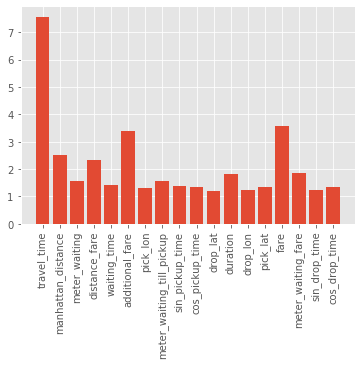

In [23]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.bar(range(len(feature_importnace)), list(feature_importnace.values()), align='center')
plt.xticks(range(len(feature_importnace)), list(feature_importnace.keys()), rotation='vertical')

plt.show